<h2>PARTE EN SUCIO</h2>

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import math
import random
from itertools import tee

In [2]:
def lectura(ruta_archivo: str):
    try:
        # Leer el contenido del archivo JSON
        with open(ruta_archivo, 'r', encoding='utf-8') as archivo:
            datos_json = json.load(archivo)

        # Acceder a todas las entradas de "galactic_object"
        objetos_galacticos = datos_json.get("galactic_object", {})

        if objetos_galacticos:
            map = {}

            # Iterar a través de todas las entradas de "galactic_object"
            for id_objeto, objeto_galactico in objetos_galacticos.items():
                # Acceder e imprimir o utilizar propiedades específicas de cada "galactic_object"
                coordenada = objeto_galactico["coordinate"]
                nombre = objeto_galactico["name"]["key"]
                hyperlane = objeto_galactico.get("hyperlane",[])

                # Verificar si la longitud de hyperlane es mayor que 0, para eliminar vértices anormales
                if len(hyperlane) > 0:
                    # Guardar la información necesaria en el diccionario
                    map[int(id_objeto)] = [nombre, [(i["to"], i["length"]) for i in hyperlane], (coordenada["x"], coordenada["y"])]
            return map
        else:
            raise ValueError("La clave 'galactic_object' no existe en los datos JSON.") 
    
    except Exception as e:
        print(f"Error al leer o analizar el archivo JSON: {e}")



In [3]:
partida = lectura('../output/output1.json')

In [4]:
def test_lectura(diccionario):
    # Imprimir los 3 primeros elementos
    print('Mostrando los tres primeros sistemas de la galaxia:')
    for r in list(diccionario.items())[:3]:
        print(r[0], ": ", r[1])
    # Imprimir puntos suspensivos
    print("...")
    # Imprimir los 3 últimos elementos
    print('Mostrando los tres últimos sistemas de la galaxia:')
    for r in list(diccionario.items())[-3:]:
        print(r[0], ": ", r[1])

In [6]:
def genera_grafo(diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionarioaux = {clave: diccionarioaux[clave][1] for clave in diccionarioaux}
    grafo = nx.Graph()
    for r in diccionarioaux:
        if len(diccionarioaux[r])>0:
            grafo.add_edges_from((r, k[0]) for k in diccionarioaux[r])
    componentes_conexas = list(nx.connected_components(grafo))

    # Encontrar la componente conexa más grande
    tamanos_componentes = [len(componente) for componente in componentes_conexas]
    indice_componente_a_conservar = tamanos_componentes.index(max(tamanos_componentes))
    componente_a_conservar = list(componentes_conexas[indice_componente_a_conservar])

    # Crear un nuevo grafo con solo la componente conexa más grande
    G_componente_grande = grafo.subgraph(componente_a_conservar).copy()
    for r in diccionario.copy():
        if r not in G_componente_grande:
            diccionario.pop(r)
    return G_componente_grande

In [7]:
mapa = genera_grafo(partida)

In [8]:
def test_genera_grafo(diccionario) -> None:
    grafoaux = genera_grafo(diccionario)
    diccionarioaux = nx.to_dict_of_lists(grafoaux)
    print('Mostrando las conexiones de los tres primeros sistemas de la galaxia:')
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[:3]]
    print("...")
    print('Mostrando las conexiones de los tres últimos sistemas:')
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[-3:]]

In [10]:
def adjudica_pesos(grafo, diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionarioaux = {clave: diccionarioaux[clave][1] for clave in diccionarioaux}
    grafoaux = grafo.copy()
    for origen in diccionarioaux:
        for destino, peso in diccionarioaux[origen]:
            grafoaux[origen][destino]['weight'] = peso
        
    return grafoaux

In [11]:
pesos_mapa = adjudica_pesos(mapa, partida)

In [12]:
def test_adjudica_pesos(grafo, diccionario) -> None:
    grafoaux = adjudica_pesos(grafo, diccionario)
    diccionarioaux = {u: [(v, data['weight']) for v, data in grafoaux[u].items()] for u in grafoaux.nodes()}
    print('Distancias entre los primeros tres sistemas y sus conexiones:')
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[:3]]
    print("...")
    print('Distancias entre los tres últimos sistemas y sus conexiones:')
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[-3:]]

In [14]:
def adjudica_posiciones(grafo, diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionariox = {clave: diccionarioaux[clave][2][0] for clave in diccionarioaux}
    diccionarioy = {clave: diccionarioaux[clave][2][1] for clave in diccionarioaux}
    grafoaux = grafo.copy()
    nx.set_node_attributes(grafoaux, diccionariox, 'x')
    nx.set_node_attributes(grafoaux, diccionarioy, 'y')
    return grafoaux

In [15]:
posiciones_mapa = adjudica_posiciones(pesos_mapa, partida)

In [16]:
def test_adjudica_posiciones(grafo, diccionario) -> None:
    grafoaux = adjudica_posiciones(grafo, diccionario)
    diccionarioaux = {u: (grafoaux.nodes[u]['x'], grafoaux.nodes[u]['y']) for u in grafoaux.nodes()}
    print('Coordenadas de los tres primeros sistemas:')
    [print(u, ":", pos) for u, pos in sorted(diccionarioaux.items())[:3]]
    print("...")
    print('Coordenadas de los tres últimos sistemas:')
    [print(u, ":", pos) for u, pos in sorted(diccionarioaux.items())[-3:]]

In [18]:
def adjudica_etiquetas(grafo, diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionarioaux = {clave: diccionarioaux[clave][0] for clave in diccionarioaux}
    grafoaux = grafo.copy()
    nx.set_node_attributes(grafoaux, diccionarioaux, 'Label')
    return grafoaux

In [19]:
mapa_completo = adjudica_etiquetas(posiciones_mapa, partida)

In [20]:
def test_adjudica_etiquetas(grafo, diccionario) -> None:
    grafoaux = adjudica_etiquetas(grafo, diccionario)
    diccionarioaux = {u: grafoaux.nodes[u]['Label'] for u in grafoaux.nodes()}
    print('Etiquetas correspondientes a los tres primeros sistemas:')
    [print(u, ":", label) for u, label in sorted(diccionarioaux.items())[:3]]
    print("...")
    print('Etiquetas correspondientes a los tres últimos sistemas:')
    [print(u, ":", label) for u, label in sorted(diccionarioaux.items())[-3:]]

---
<h2><a name="Exploracion"></a><strong>2. ¿Cómo saber si se tiene un buen comienzo y cómo ejecutar la exploración?</strong></h2>
<p>Sabiendo ya la forma que tiene nuestra galaxia y cómo funciona, podremos ubicarnos en ésta y plantear ya nuestra estrategia para comenzar con nuestra expansión por el espacio.</p>
<p>Sólo hay una variable que hace que a la hora de tomar ciertas decisiones hagamos una cosa u otra. Así es, hablamos del <strong>comienzo</strong>.</p>
<p>Que hayamos empezado de <em>x</em> manera en la galaxia repercute en nuestra manera de explorar y reunir información suficiente para conquistar o no ciertos sistemas y así extender nuestros dominios de la <strong>manera más eficiente</strong>. Una mala decisión puede acabar en una posible caída de nuestro imperio por posición estratégica.</p>
<p></p>
<p>Para empezar debemos ver qué sistemas de la galaxia nos permite aislar otros sistemas si son tomadas. Para ello la función <em>puntos_de-corte_y_aislamiento()</em> nos dirá cuáles son esos sistemas que aislan otros sistemas si son conquistadas y cuáles son aquellos sistemas que se aislan:</p>

In [22]:
def puntos_de_corte_y_aislamiento(grafo: nx.Graph):
    dicc = dict()
    for i in list(nx.articulation_points(grafo)):
        grafoaux = grafo.copy()
        grafoaux.remove_node(i)
        dicc[i] = sorted(nx.connected_components(grafoaux), key=len, reverse=True)[1:]
    for i in dicc:
        dicc[i] = [elemento for sublista in dicc[i] for elemento in sublista]
    return dicc

<p>- Test de <em>puntos_de_corte_y_aislamiento()</em>:</p>

In [23]:
puntos_corte_g = puntos_de_corte_y_aislamiento(mapa_completo)
print('Mostrando los tres primeros sistemas de corte:')
for r in sorted(puntos_corte_g)[:3]:
    print(str(r) +  ":" + ((3-len(str(r)))*" ") +str(puntos_corte_g[r]))
print("...")
print('Mostrando los tres últimos sistemas de corte:')
for r in sorted(puntos_corte_g)[-3:]:
    print(str(r) +  ":" + ((3-len(str(r)))*" ") +str(puntos_corte_g[r]))

Mostrando los tres primeros sistemas de corte:
5:  [223]
12: [168, 75, 19]
20: [242, 156]
...
Mostrando los tres últimos sistemas de corte:
361:[165, 71, 297, 28, 210, 152, 276, 63, 184, 25, 188, 189, 95]
362:[276, 152, 25, 154, 28, 165, 295, 297, 308, 184, 57, 188, 189, 63, 71, 210, 339, 95, 361, 106, 123]
394:[289]


<p>Teniendo ya los sistemas de corte disponibles, sólo necesitaremos aquellos que sean <strong>maximales</strong>, es decir, aquellos puntos de corte que no pueden ser separados del grafo principal mediante otro punto de corte con el fin de evitar la saturación del mapa de puntos de cortes rebundantes.</p>

In [24]:
def elimina_redundancias(dicc: dict):
    diccaux = dicc.copy()
    conjunto_aislante={r[0] for r in diccaux.items()}
    conjunto_aislado={j for i in diccaux.items() for j in i[1]}
    for r in dicc:
        if r not in conjunto_aislante.difference(conjunto_aislado):
            diccaux.pop(r)
    return diccaux

<p>- Test de <em>elimina_rebundancias()</em>:</p>

In [25]:
puntos_corte_maximales_g = elimina_redundancias(puntos_corte_g)
print('Mostrando los tres primeros sistemas de corte maximales:')
for r in sorted(puntos_corte_maximales_g)[:3]:
    print(str(r) + ": " + ((3-len(str(r)))*" ") + str(puntos_corte_maximales_g[r]))
print("...")
print('Mostrando los tres últimos sistemas de corte maximales:')
for r in sorted(puntos_corte_maximales_g)[-3:]:
    print(str(r) + ": " + ((3-len(str(r)))*" ") + str(puntos_corte_maximales_g[r]))

Mostrando los tres primeros sistemas de corte maximales:
5:   [223]
20:  [242, 156]
36:  [150]
...
Mostrando los tres últimos sistemas de corte maximales:
347: [353, 322]
362: [276, 152, 25, 154, 28, 165, 295, 297, 308, 184, 57, 188, 189, 63, 71, 210, 339, 95, 361, 106, 123]
394: [289]


<p>Una vez que tengamos los sistemas de corte maximales determinados, debemos de saber cuál es la distancia a la que debemos aspirar recorrer a lo largo de la galaxia en base al número de países que se encuentran en la galaxia.</p>
<p>Gracias a la función <em>topedist()</em> podremos saber cuál es esa <strong>distancia máxima</strong> que debemos aspirar a la hora de iniciar nuestra conquista.</p>
<p>Una cosa a tener en consideración es que el parámetro <em>numParticipantes</em> se refiere al número de países que se encuentran en la galaxia. Esto es importante debido a que <em>Stellaris</em> es un juego de estrategia multijugador a tiempo real, es decir, que ciertos sistemas pueden ser controlados por dichos paises, paises que tratarán de evitar a toda costa la toma de dicho sistema si es importante.</p>

In [26]:
def topedist(grafo: nx.Graph, numParticipantes: int):
    lis = [w[2]["weight"] for w in grafo.edges(data=True)]
    avglongitud = sum(lis)/len(lis)
    pesototal = sum([w[2]["weight"] for w in grafo.edges(data=True)])
    pesoporpart = 1.2*pesototal/numParticipantes
    saltos = math.log(pesoporpart, ((grafo.number_of_edges()*2)/grafo.number_of_nodes()-1))
    return saltos*avglongitud

In [27]:
print("La distancia máxima a la que deberíamos aspirar es:",topedist(mapa_completo, 10))

La distancia máxima a la que deberíamos aspirar es: 285.21651250106396


<p>Ahora que hemos determinado la distancia máxima a la que es sensato aspirar, podemos determinar que tan bueno es nuestro origen según la distancia a los puntos de corte maximales:</p>

In [28]:
def rankea(grafo: nx.Graph, dicc_corte: dict, numpart: int):
    ranking = dict()
    toped = topedist(grafo, numpart)
    for i in grafo.nodes():
        punt=0
        for j in dicc_corte:
            dist = nx.shortest_path_length(grafo, i, j, weight="weight")
            if dist<toped:
                punt+=(len(dicc_corte[j])*(toped-dist)/toped)
        ranking[i] = punt
    return ranking

<p>- Test de <em>rankea()</em>:</p>

In [29]:
ranking = rankea(mapa_completo, puntos_corte_maximales_g, 10)
maximo = max([ranking[an] for an in ranking])
rankingordenado = [(r[0], 10*r[1]/maximo) for r in sorted(ranking.items(),key=lambda a:a[1], reverse=True)]

In [30]:
print("Imprimiento los diez mejores sistemas:")
for r in range(10):
    print(rankingordenado[r])

Imprimiento los diez mejores sistemas:
(362, 10.0)
(154, 9.43128099401655)
(320, 9.30607571862525)
(308, 9.052590496842432)
(226, 8.95510374851692)
(262, 8.809044441084215)
(375, 8.673899999668315)
(57, 8.598161900233489)
(106, 8.37094760192902)
(103, 8.337812183426282)


In [31]:
print("Imprimiento los diez peores sistemas:")
for r in range(10):
    print(rankingordenado[-(r+1)])

Imprimiento los diez peores sistemas:
(210, 0.4710700913721236)
(156, 0.6223668264164475)
(242, 0.772053791587516)
(84, 1.1220008713624412)
(121, 1.2075478633377525)
(71, 1.5976743204651267)
(228, 1.6099065165852535)
(193, 1.6224484500148186)
(319, 1.666287377907331)
(20, 1.6864581497264612)


<p>Para mayor claridad representaremos el grafo, dándole color y tamaño a los nodos según su puntuación:</p>

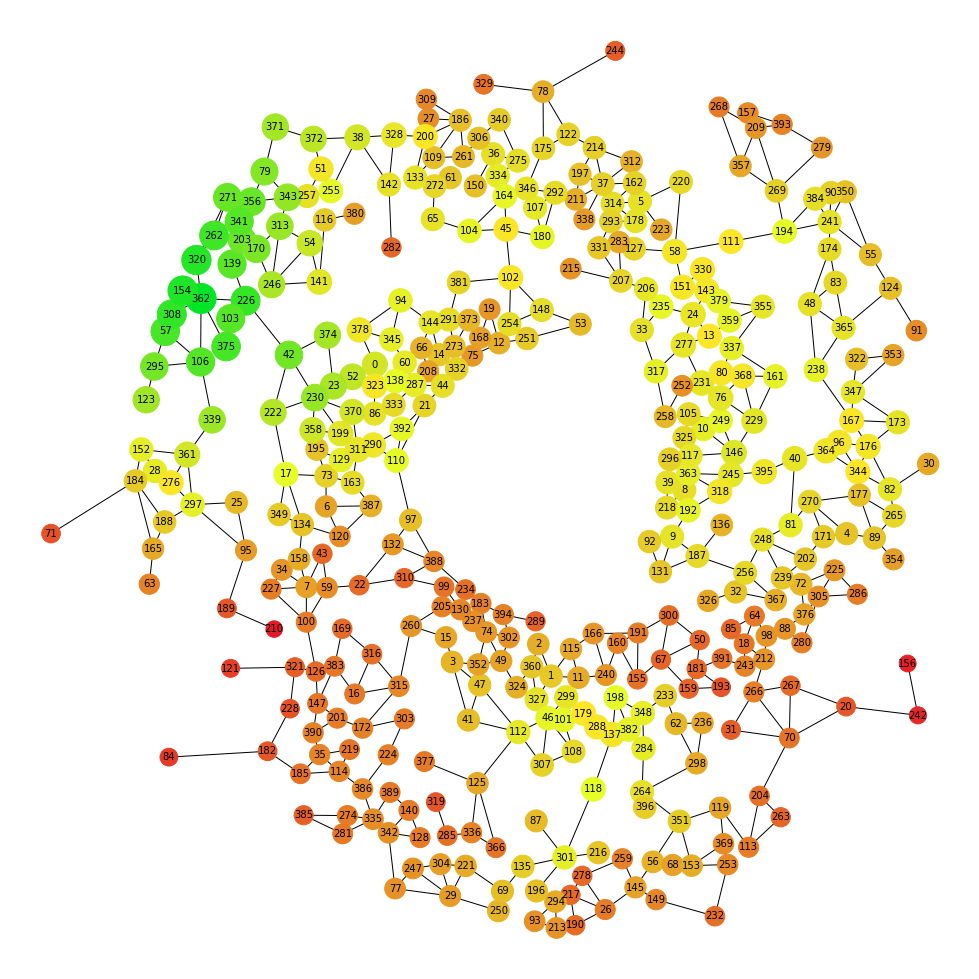

In [32]:
nodo_posiciones = {nodo: (mapa_completo.nodes[nodo]['x'], mapa_completo.nodes[nodo]['y']) for nodo in mapa_completo.nodes}
nodo_colores = [
    (2 * (1 - (ranking[r] / maximo)), 0.9, 0.15) 
    if ranking[r]/maximo > 0.5 
    else (0.9, 2 * (ranking[r] / maximo), 0.15) for r in ranking]
nodo_tamano = [30*(8+r[1]) for r in ranking.items()]
plt.figure(figsize=(13.4,13.4))
nx.draw(mapa_completo,with_labels=True, pos=nodo_posiciones, font_size=10, node_color=nodo_colores, node_size=nodo_tamano)

<p><strong><em>¿Quieres mejorar el algoritmo?</em></strong></p>
<p>Prueba a hacer que tenga en cuenta conjuntos de corte que desconecten el grafo, deberás tener en cuenta cuantos puntos son necesarios para desconectar el grafo, así como la distancia entre ellos, un posible comienzo sería:</p>

<em>
(Tamaño del sector aislado * (distancia maxima - ruta mas corta que atraviese el conjunto de corte)) /(tamaño del conjunto de corte * distancia maxima)
</em>

<p>Ahora que ya sabemos que tan bueno o malo es nuestro origen debemos determinar por dónde ha de empezar nuestra <strong>expansión galactica</strong>, obtendremos en primer lugar las rutas a los puntos de interés:</p>

In [33]:
def destinos_posibles(grafo: nx.Graph, puntoinicio: int,participantes: int):
    grafoaux = grafo.copy()
    distancias, caminos = nx.single_source_dijkstra(grafoaux, puntoinicio)
    limite = topedist(grafo, participantes)
    destinos = puntos_de_corte_y_aislamiento(grafo)
    for r in distancias:
        if(distancias[r]>limite):
            grafoaux.remove_node(r)
        if (r not in destinos or distancias[r]>limite):
            caminos.pop(r)
    
    return grafoaux, caminos

In [34]:
origen = 130

In [35]:
subg, caminos = destinos_posibles(mapa_completo, origen, 10)

In [36]:
print("Todos los posibles puntos de interés para nuestro origen son: ", list(caminos.keys()))

Todos los posibles puntos de interés para nuestro origen son:  [394, 112, 125, 321, 336, 182, 335, 301, 285, 264]


<p>Representamos las rutas a esos caminos en el mapa:</p>

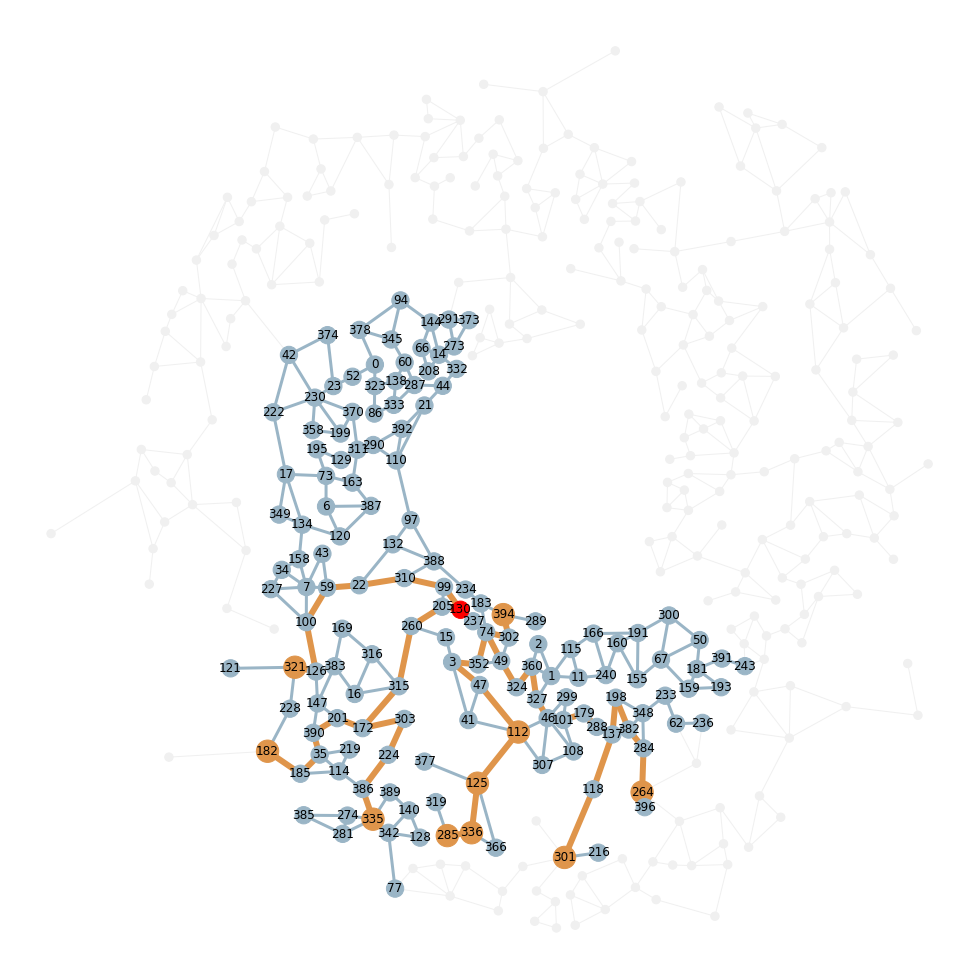

In [37]:
conjunto = set()
for r in caminos:
    if caminos[r][-1] in caminos:
        conjunto.update([(caminos[r][k], caminos[r][k+1]) for k in range(len(caminos[r])-1)])
nodo_colores = [
    "#DF954B" if (r in puntos_corte_g and r in subg.nodes())
    else "red" if r == 130 
    else "#9AB5C6" if r in subg.nodes() 
    else "#F0F0F0" for r in mapa_completo.nodes()]
arista_colores = [
    "#DF954B" if ((r[0],r[1]) in conjunto or (r[1],r[0]) in conjunto) 
    else "#9AB5C6" if r in subg.edges() 
    else  "#F0F0F0" for r in mapa_completo.edges()]
arista_tamano = [
    6 if ((r[0],r[1]) in conjunto or (r[1],r[0]) in conjunto) 
    else 3 if r in subg.edges() 
    else 1 for r in mapa_completo.edges()]
nodo_etiquetas={r: r if r in subg.nodes() else "" for r in mapa_completo.nodes()}
nodo_tamano = [
    500 if r in subg.nodes() and r in puntos_corte_g 
    else 300 if r in subg.nodes()
    else 70 for r in mapa_completo.nodes()]
plt.figure(figsize=(13.4,13.4))
nx.draw(
    mapa_completo, 
    node_size=nodo_tamano, 
    labels=nodo_etiquetas, 
    pos=nodo_posiciones, 
    node_color=nodo_colores, 
    edge_color=arista_colores, 
    width=arista_tamano
)

<p>Es tiempo ahora de determinar los puntos de máximo interés, pues como podemos ver en la representación hay puntos que no son relevantes en comparación a otros. Tenemos que saber también <strong>cómo expandirnos</strong> considerando que no es necesario ocupar todos los sistemas que hay presentes, con sólo los maximales de corte nos vale.</p>

In [38]:
def explora(grafo: nx.Graph, dicc_corte: dict, numpart: int, origen:int):
    toped = topedist(grafo, numpart)
    pesos, caminos = nx.single_source_dijkstra(grafo,origen)
    pesos = {r: pesos[r] for r in pesos if r in dicc_corte and r != origen}
    caminos = {r: caminos[r] for r in caminos if r in dicc_corte and r != origen}
    puntuacion_dict = dict()
    caminos_finales=dict()
    for i in pesos:
        if pesos[i]<toped:
            puntuacion_dict[i] = (len(dicc_corte[i])*(toped-pesos[i])/toped)
            caminos_finales[i]=caminos[i]
    for i in caminos:
        for j in caminos[i]:
            if i in puntuacion_dict and j in puntuacion_dict and puntuacion_dict[i]<puntuacion_dict[j] and i in dicc_corte[j]:
                puntuacion_dict.pop(i)
                caminos_finales.pop(i)
    return puntuacion_dict, caminos_finales

In [39]:
mejores_destinos, caminos_finales = explora(mapa_completo,puntos_corte_g , 10, origen)
print(f"El mejor destino es el {max(mejores_destinos.items(), key=lambda a:a[1])[0]}, con una puntuacion de {max(mejores_destinos.items(), key=lambda a:a[1])[1]}")

El mejor destino es el 112, con una puntuacion de 3.223162175797779


<p>Gracias a la función <em>explora()</em> hemos podido evaluar el destino que deberíamos priorizar en nuestra exploración.</p>

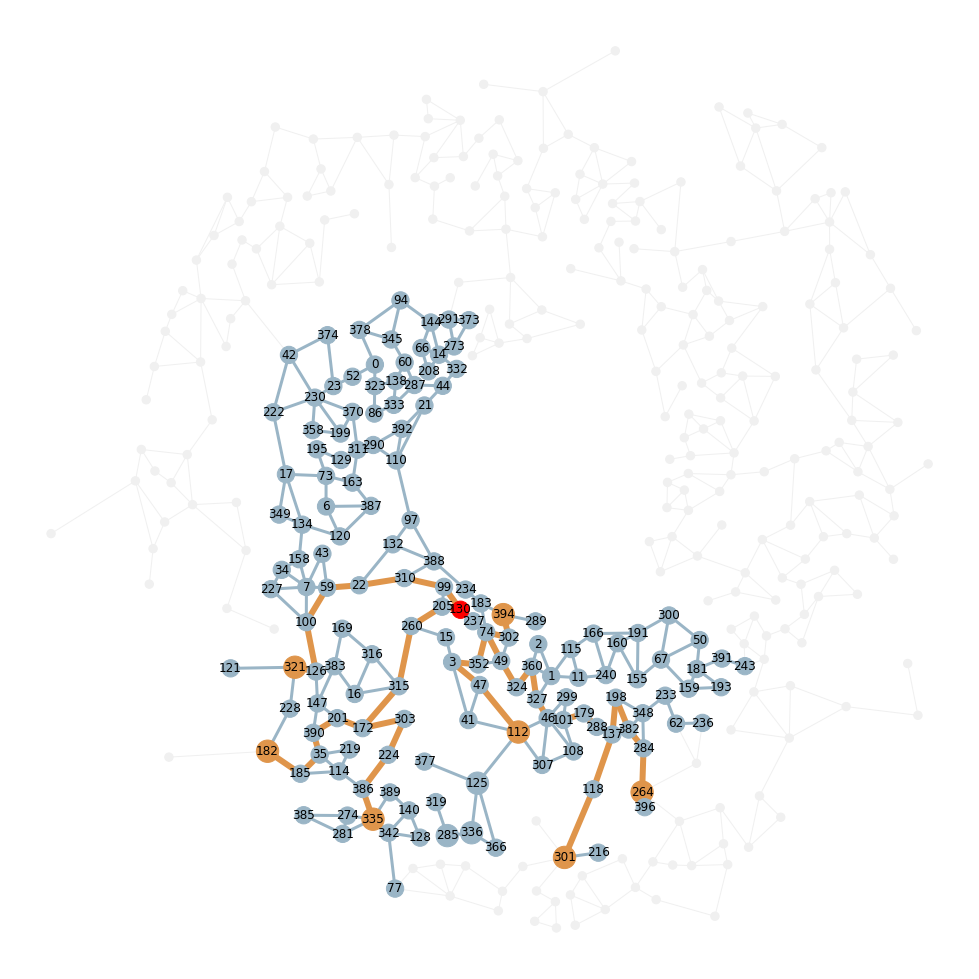

In [40]:
conjunto = set()
for r in caminos_finales:
    if caminos[r][-1] in caminos_finales:
        conjunto.update([(caminos_finales[r][k], caminos_finales[r][k+1]) for k in range(len(caminos[r])-1)])
nodo_colores = [
    "#DF954B" if (r in mejores_destinos and r in subg.nodes())
    else "red" if r == 130 
    else "#9AB5C6" if r in subg.nodes() 
    else "#F0F0F0" for r in mapa_completo.nodes()]
arista_colores = [
    "#DF954B" if ((r[0],r[1]) in conjunto or (r[1],r[0]) in conjunto) 
    else "#9AB5C6" if r in subg.edges() 
    else  "#F0F0F0" for r in mapa_completo.edges()]
arista_tamano = [
    6 if ((r[0],r[1]) in conjunto or (r[1],r[0]) in conjunto) 
    else 3 if r in subg.edges() 
    else 1 for r in mapa_completo.edges()]
nodo_etiquetas={r: r if r in subg.nodes() else "" for r in mapa_completo.nodes()}
nodo_tamano = [
    500 if r in subg.nodes() and r in puntos_corte_g 
    else 300 if r in subg.nodes()
    else 70 for r in mapa_completo.nodes()]
plt.figure(figsize=(13.4,13.4))
nx.draw(
    mapa_completo, 
    node_size=nodo_tamano, 
    labels=nodo_etiquetas, 
    pos=nodo_posiciones, 
    node_color=nodo_colores, 
    edge_color=arista_colores, 
    width=arista_tamano
)

<p>De los posibles destinos a los que podemos viajar, tenemos que ver la ruta que pasa por la máxima cantidad de sistemas de interés sin desviarse demasiado.</p>

In [41]:
def traductor_de_rutas(grafo: nx.Graph, caminos: dict):
    diccaux=dict()
    for r in caminos:
        diccaux[r] = [(caminos[r][k], caminos[r][k+1]) for k in range(len(caminos[r])-1)]
    return diccaux

In [42]:
rutas_finales_aristas = traductor_de_rutas(mapa_completo, caminos_finales)
print(rutas_finales_aristas)

{394: [(130, 237), (237, 74), (74, 302), (302, 394)], 112: [(130, 237), (237, 74), (74, 352), (352, 3), (3, 47), (47, 112)], 321: [(130, 99), (99, 310), (310, 22), (22, 59), (59, 100), (100, 126), (126, 321)], 182: [(130, 205), (205, 260), (260, 315), (315, 172), (172, 201), (201, 390), (390, 35), (35, 185), (185, 182)], 335: [(130, 205), (205, 260), (260, 315), (315, 172), (172, 303), (303, 224), (224, 386), (386, 335)], 301: [(130, 237), (237, 74), (74, 49), (49, 324), (324, 360), (360, 327), (327, 46), (46, 101), (101, 179), (179, 288), (288, 137), (137, 118), (118, 301)], 264: [(130, 237), (237, 74), (74, 49), (49, 324), (324, 360), (360, 327), (327, 46), (46, 101), (101, 179), (179, 288), (288, 137), (137, 198), (198, 382), (382, 284), (284, 264)]}


<p>Podemos observar que la función <em>mejores_rutas()</em> nos devuelve un diccionario cuyas claves son los sistemas de interés y los valores son la lista de aristas que se tienen que cruzar para llegar a éstos sistemas.</p>
<p>Teniendo en cuenta el diccionario que nos devuelve la función, podemos generar posibles combinaciones de las rutas que debemos tomar para ocupar los <strong>sistemas de interés</strong>. Gracias a la siguiente sucesión de funciones, podemos crear dichas combinaciones y añadirlas en una lista.</p>

In [43]:
def generar_combinaciones(lista):
    result = []

    for i in range(1, len(lista) + 1):
        combinaciones_i = get_combinaciones(lista, i)
        result.extend(combinaciones_i)

    return result

def get_combinaciones(lista, longitud):
    result = []
    combinacion_actual = [0] * longitud

    generar_combinaciones_util(lista, result, combinacion_actual, 0, len(lista) - 1, 0, longitud)

    return result

def generar_combinaciones_util(lista, result, combinacion_actual, inicio, fin, indice_actual, longitud):
    if indice_actual == longitud:
        result.append(combinacion_actual.copy())
        return

    i = inicio
    while i <= fin and fin - i + 1 >= longitud - indice_actual:
        combinacion_actual[indice_actual] = lista[i]
        generar_combinaciones_util(lista, result, combinacion_actual, i + 1, fin, indice_actual + 1, longitud)
        i += 1

In [44]:
resultados = generar_combinaciones(list(rutas_finales_aristas.keys()))
print(resultados)

[[394], [112], [321], [182], [335], [301], [264], [394, 112], [394, 321], [394, 182], [394, 335], [394, 301], [394, 264], [112, 321], [112, 182], [112, 335], [112, 301], [112, 264], [321, 182], [321, 335], [321, 301], [321, 264], [182, 335], [182, 301], [182, 264], [335, 301], [335, 264], [301, 264], [394, 112, 321], [394, 112, 182], [394, 112, 335], [394, 112, 301], [394, 112, 264], [394, 321, 182], [394, 321, 335], [394, 321, 301], [394, 321, 264], [394, 182, 335], [394, 182, 301], [394, 182, 264], [394, 335, 301], [394, 335, 264], [394, 301, 264], [112, 321, 182], [112, 321, 335], [112, 321, 301], [112, 321, 264], [112, 182, 335], [112, 182, 301], [112, 182, 264], [112, 335, 301], [112, 335, 264], [112, 301, 264], [321, 182, 335], [321, 182, 301], [321, 182, 264], [321, 335, 301], [321, 335, 264], [321, 301, 264], [182, 335, 301], [182, 335, 264], [182, 301, 264], [335, 301, 264], [394, 112, 321, 182], [394, 112, 321, 335], [394, 112, 321, 301], [394, 112, 321, 264], [394, 112, 182,

<p>Teniendo la lista de todas las rutas posibles para realizar, calcularemos el peso de estas rutas:</p>

In [45]:
def peso_desde_ruta(grafo: nx.Graph, ruta: list):
    return sum([grafo.edges()[r]["weight"] for r in ruta])
peso_desde_ruta(mapa_completo,rutas_finales_aristas[112])

132

<p>Ahora podemos ver cuáles son las rutas que comparten la gran mayoría de sus <strong>elementos</strong> (en este caso los sistemas) para filtrar la lista previa de las rutas, dejando sólo las rutas con mayor interés.</p>

In [46]:
#Ahora vemos cuales rutas comparten la mayoria de sus elementos
def ruta_maximal(grafo: nx.Graph, lista_combinaciones: list,rutas: dict):
    dicc_pesos= dict()
    for i in lista_combinaciones:
        for j in i:
            dicc_pesos[j] = peso_desde_ruta(grafo, rutas[j])
    combinaciones_interesantes= dict()
    for i in lista_combinaciones:
        elemento_maximo, ruta_maxima, peso_maximo = max([ (r,rutas[r], peso_desde_ruta(grafo, rutas[r])) for r in i], key=lambda a:a[1])
        flag_es_almacenado=True
        for j in i:
            if j!=elemento_maximo:
                conjunto_caminos=set()
                conjunto_caminos.update(ruta_maxima)
                conjunto_caminos.update(rutas[j])
                if peso_desde_ruta(grafo, conjunto_caminos)-peso_maximo>(peso_desde_ruta(grafo,rutas[j])/2):
                    flag_es_almacenado=False
        if(flag_es_almacenado):
            conjunto_caminos=set()
            for j in i:
                conjunto_caminos.update(rutas[j])    
            combinaciones_interesantes[tuple(i)]=conjunto_caminos

    return(combinaciones_interesantes)

In [47]:
rutas_maximales=ruta_maximal(subg, resultados, rutas_finales_aristas)
for r in rutas_maximales:
    print(str(r) + ":",rutas_maximales[r])

(394,): {(130, 237), (74, 302), (237, 74), (302, 394)}
(112,): {(3, 47), (47, 112), (130, 237), (74, 352), (352, 3), (237, 74)}
(321,): {(126, 321), (99, 310), (310, 22), (22, 59), (59, 100), (130, 99), (100, 126)}
(182,): {(201, 390), (35, 185), (185, 182), (205, 260), (315, 172), (260, 315), (390, 35), (130, 205), (172, 201)}
(335,): {(172, 303), (205, 260), (315, 172), (303, 224), (260, 315), (130, 205), (386, 335), (224, 386)}
(301,): {(327, 46), (74, 49), (324, 360), (46, 101), (118, 301), (137, 118), (101, 179), (130, 237), (360, 327), (179, 288), (288, 137), (237, 74), (49, 324)}
(264,): {(137, 198), (327, 46), (74, 49), (324, 360), (46, 101), (101, 179), (198, 382), (382, 284), (130, 237), (284, 264), (360, 327), (179, 288), (288, 137), (237, 74), (49, 324)}
(182, 335): {(201, 390), (172, 303), (35, 185), (185, 182), (205, 260), (315, 172), (303, 224), (260, 315), (390, 35), (130, 205), (386, 335), (172, 201), (224, 386)}
(301, 264): {(137, 198), (327, 46), (74, 49), (324, 360)

<p>Ahora que tenemos todas las rutas interesantes tenemos que ver cuál es la mejor de todas, y simplemente sumaremos la puntuación que otorgan a nuestro sistema inicial.</p>

In [48]:
rutas_y_pesos = list()
for i in rutas_maximales.keys():
    lista=list()
    for j in i:
        lista.append(mejores_destinos[j])
    rutas_y_pesos.append((i, tuple(lista)))
ruta_maxima = max(rutas_y_pesos, key=lambda a:sum(a[1]))[0]
print(f"La mejor ruta pasa por los puntos: {ruta_maxima}, y tiene un peso de {sum([mejores_destinos[r] for r in ruta_maxima])}")    

La mejor ruta pasa por los puntos: (112,), y tiene un peso de 3.223162175797779


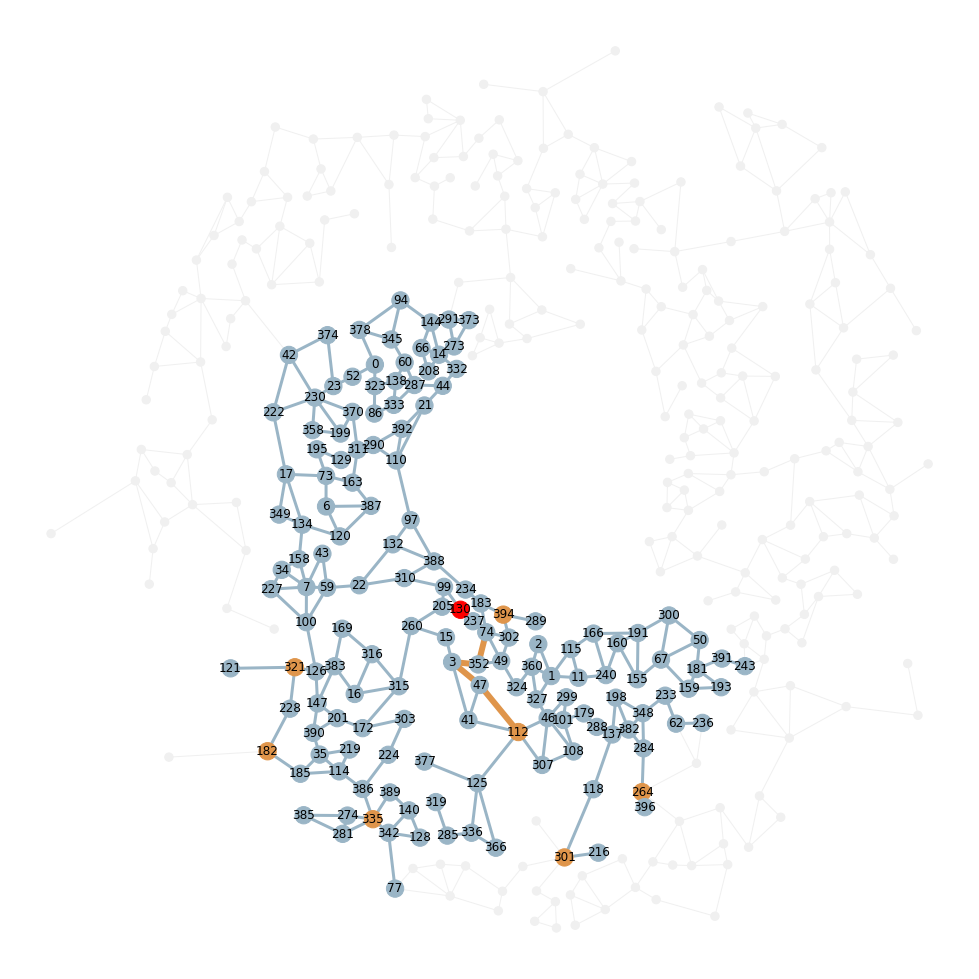

In [49]:
conjunto = set()
for r in mejores_destinos:
    if caminos[r][-1] in mejores_destinos:
        conjunto.update([(caminos[r][k], caminos[r][k+1]) for k in range(len(caminos[r])-1)])
nodo_colores = [
    "#DF954B" if (r in mejores_destinos and r in subg.nodes())
    else "red" if r == 130 
    else "#9AB5C6" if r in subg.nodes() 
    else "#F0F0F0" for r in mapa_completo.nodes()]
arista_colores = [
    "#DF954B" if ((r[0],r[1]) in rutas_maximales[ruta_maxima] or (r[1],r[0]) in rutas_maximales[ruta_maxima]) 
    else "#9AB5C6" if r in subg.edges() 
    else  "#F0F0F0" for r in mapa_completo.edges()]
arista_tamano = [
    6 if ((r[0],r[1]) in rutas_maximales[ruta_maxima] or (r[1],r[0]) in rutas_maximales[ruta_maxima]) 
    else 3 if r in subg.edges() 
    else 1 for r in mapa_completo.edges()]
nodo_etiquetas={r: r if r in subg.nodes() else "" for r in mapa_completo.nodes()}
nodo_tamano = [
    500 if r in subg.nodes() and r in rutas_maximales[ruta_maxima] 
    else 300 if r in subg.nodes()
    else 70 for r in mapa_completo.nodes()]
plt.figure(figsize=(13.4,13.4))
nx.draw(mapa_completo, 
        node_size=nodo_tamano, 
        labels=nodo_etiquetas, 
        pos=nodo_posiciones, 
        node_color=nodo_colores, 
        edge_color=arista_colores, 
        width=arista_tamano
)

### Propuesta
<p>Aplica el tsp del ej 5 a las combinaciones de rutas encontradas previamente.</p>
<p>Basta con coger todas las combinaciones de los elementos, dar la ruta que los recorre todos, y eliminar la arista más larga que vaya a el punto origen, esto serviría para calcular de una forma exacta el peso de nuestra nueva ruta, lo que nos permitiría evaluar de forma más eficiente.</p>